# NYC Metro Challenge

## Field Description

- C/A = Control Area (A002)
- UNIT = Remote Unit for a station (R051)
- SCP = Subunit Channel Position represents an specific address for a device (02-00-00)
- DATEn = Represents the date (MM-DD-YY)
- TIMEn = Represents the time (hh:mm:ss) for a scheduled audit event
- DEScn = Represent the "REGULAR" scheduled audit event (occurs every 4 hours)
- ENTRIESn = The cumulative entry register value for a device
- EXISTn = The cumulative exit register value for a device

In [18]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(style='darkgrid')

import glob
import shutil
import py7zr

## Understanding the Dataset

Let`s begin importing just one dataset and work to understand the data

In [226]:
file_name = glob.glob('data/*.7z')
temp_folder = 'data/temp'

with py7zr.SevenZipFile(file_name[0], 'r') as archive:
    file_names = archive.getnames()
    archive.extractall(path=temp_folder)

path_data_sets = glob.glob(temp_folder + '/*/*')

df = pd.read_csv(path_data_sets[0])

try:
    shutil.rmtree(temp_folder)
except OSError as e:
   print("Error: %s - %s." % (e.filename, e.strerror))

In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7420384 entries, 0 to 7420383
Data columns (total 10 columns):
 #   Column    Dtype  
---  ------    -----  
 0   time      object 
 1   ca        object 
 2   unit      object 
 3   scp       object 
 4   station   object 
 5   linename  object 
 6   division  object 
 7   desc      object 
 8   entries   float64
 9   exits     float64
dtypes: float64(2), object(8)
memory usage: 566.1+ MB


In [228]:
df.head(1)

,time,ca,unit,scp,station,linename,division,desc,entries,exits
0,2010-04-17 04:00:00,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2704717.0,928793.0


The columns are different from the field description. Since the original page of the data is not available, I'll have to guess here.

- time: datetime column;
- ca: should be this control area geo-field;
- unit: from a quick search this field means the order of the station in a traveline;
- scp: is this subunit channel position, like a ticket gate or turnstile where passengers count happens;
- station: station name;
- linename: each character from this string is a line that pass in this station;
- division: from a reseach on the internet I've found:
    - 'IRT': 'Interborough Rapid Transit',
    - 'BMT': 'Brooklyn-Manhattan Transit',  
    - 'IND': 'Independent Subway',
    - 'PTH': 'Port Authority Trans-Hudson (PATH)',
    - 'RIT': 'Roosevelt Island Tram',
    - 'SRT': 'Staten Island Rapid Transit' 
- desc: represents the audit event when the count was measured. The value 'REGULAR' means a the most regular measurement from every 4 hours;
- entries: cumulative register of each passenger thought the ticket gate;
- exits: cumulative register of each passenger thought the ticket gate;

In [230]:
df.shape

(7420384, 10)

First transform the time columns from object to timestamp.

In [233]:
df['time'] = pd.to_datetime(df['time'])

Count how many unique values are on each object column.

In [234]:
for column in df.columns:
        if df[column].dtypes == np.object0:
            print(f'{column.ljust(12)} {df[column].nunique()}')


ca           727
unit         467
scp          213
station      382
linename     107
division     6
desc         13


The number of unique values is very small compared to the entire data frame. Let's convert these columns to categorical type.

In [235]:
object_columns = [_ for _ in df.columns if df[_].dtype == np.object0]
for column in object_columns:
        df[column] = pd.Categorical(df[column])

In [236]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7420384 entries, 0 to 7420383
Data columns (total 10 columns):
 #   Column    Dtype         
---  ------    -----         
 0   time      datetime64[ns]
 1   ca        category      
 2   unit      category      
 3   scp       category      
 4   station   category      
 5   linename  category      
 6   division  category      
 7   desc      category      
 8   entries   float64       
 9   exits     float64       
dtypes: category(7), datetime64[ns](1), float64(2)
memory usage: 247.7 MB


The entries and exits are a discrete count so let's convert to integer type.

In [237]:
df['entries'] = df['entries'].astype('int')
df['exits'] = df['exits'].astype('int')

In [238]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7420384 entries, 0 to 7420383
Data columns (total 10 columns):
 #   Column    Dtype         
---  ------    -----         
 0   time      datetime64[ns]
 1   ca        category      
 2   unit      category      
 3   scp       category      
 4   station   category      
 5   linename  category      
 6   division  category      
 7   desc      category      
 8   entries   int32         
 9   exits     int32         
dtypes: category(7), datetime64[ns](1), int32(2)
memory usage: 191.1 MB


The memory occupied by this dataframe is reasonably small, so let's work with it in its entirety without having to sample it.

In [239]:
df.head()

,time,ca,unit,scp,station,linename,division,desc,entries,exits
0,2010-04-17 04:00:00,A002,R051,02-00-00,LEXINGTON AVE,456NQR,BMT,REGULAR,2704717,928793
1,2010-04-17 04:00:00,A002,R051,02-00-01,LEXINGTON AVE,456NQR,BMT,REGULAR,2697632,566683
2,2010-04-17 04:00:00,A002,R051,02-03-00,LEXINGTON AVE,456NQR,BMT,REGULAR,1127722,3943492
3,2010-04-17 04:00:00,A002,R051,02-03-01,LEXINGTON AVE,456NQR,BMT,REGULAR,2425570,3733289
4,2010-04-17 04:00:00,A002,R051,02-03-02,LEXINGTON AVE,456NQR,BMT,REGULAR,2214633,3021589


We can convert this linename column to a set type in the case of geo forecasting.

In [242]:
df['linename'] = df['linename'].astype('str')
df['linename'] = df['linename'].apply(set)

In [243]:
df.head()

,time,ca,unit,scp,station,linename,division,desc,entries,exits
0,2010-04-17 04:00:00,A002,R051,02-00-00,LEXINGTON AVE,"{4, 5, R, 6, Q, N}",BMT,REGULAR,2704717,928793
1,2010-04-17 04:00:00,A002,R051,02-00-01,LEXINGTON AVE,"{4, 5, R, 6, Q, N}",BMT,REGULAR,2697632,566683
2,2010-04-17 04:00:00,A002,R051,02-03-00,LEXINGTON AVE,"{4, 5, R, 6, Q, N}",BMT,REGULAR,1127722,3943492
3,2010-04-17 04:00:00,A002,R051,02-03-01,LEXINGTON AVE,"{4, 5, R, 6, Q, N}",BMT,REGULAR,2425570,3733289
4,2010-04-17 04:00:00,A002,R051,02-03-02,LEXINGTON AVE,"{4, 5, R, 6, Q, N}",BMT,REGULAR,2214633,3021589


Now let's try to compute the instantaneous value of entries and exits instead of the cumulative count.
 - For each time, station and ticket gate.

In [244]:
df_test = df.copy()

In [261]:
df_test = df_test.sort_values(by=['station', 'scp'])
df_test['entries_diff'] = df_test.groupby(['station', 'scp'])['entries'].diff().fillna(0)
df_test['exits_diff'] = df_test.groupby(['station', 'scp'])['exits'].diff().fillna(0)

In [262]:
df_test.head()

,time,ca,unit,scp,station,linename,division,desc,entries,exits,entries_diff,exits_diff
376,2010-04-17 04:00:00,H007,R248,00-00-00,1 AVE,{L},BMT,REGULAR,2881236,3240099,0.0,0.0
5376,2010-04-17 08:00:00,H007,R248,00-00-00,1 AVE,{L},BMT,REGULAR,2881370,3240352,134.0,253.0
5377,2010-04-17 08:00:00,H007,R248,00-00-00,1 AVE,{L},BMT,RECOVR,2881370,3240352,0.0,0.0
11241,2010-04-17 12:00:00,H007,R248,00-00-00,1 AVE,{L},BMT,AUD,2881444,3240584,74.0,232.0
16292,2010-04-17 16:00:00,H007,R248,00-00-00,1 AVE,{L},BMT,REGULAR,2881942,3241295,498.0,711.0


The groupby

Now we check if this cumulative entries and exits count grow in a regular speed.
- First choosing on station and one ticket gate.

In [263]:
df_sample = df_test[(df_test['station'] == '1 AVE') & (df_test['scp'] == '00-00-00')]

In [264]:
df_sample.head()

,time,ca,unit,scp,station,linename,division,desc,entries,exits,entries_diff,exits_diff
376,2010-04-17 04:00:00,H007,R248,00-00-00,1 AVE,{L},BMT,REGULAR,2881236,3240099,0.0,0.0
5376,2010-04-17 08:00:00,H007,R248,00-00-00,1 AVE,{L},BMT,REGULAR,2881370,3240352,134.0,253.0
5377,2010-04-17 08:00:00,H007,R248,00-00-00,1 AVE,{L},BMT,RECOVR,2881370,3240352,0.0,0.0
11241,2010-04-17 12:00:00,H007,R248,00-00-00,1 AVE,{L},BMT,AUD,2881444,3240584,74.0,232.0
16292,2010-04-17 16:00:00,H007,R248,00-00-00,1 AVE,{L},BMT,REGULAR,2881942,3241295,498.0,711.0


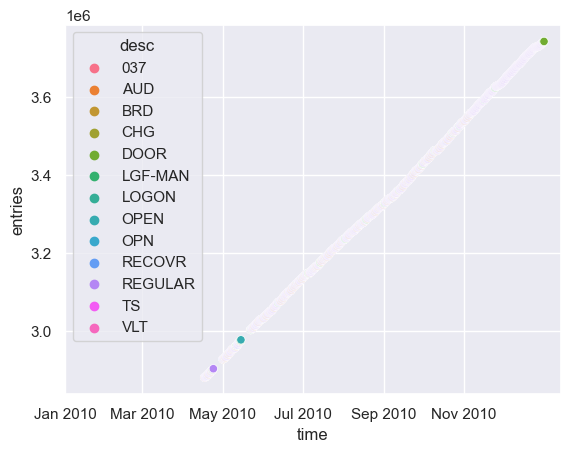

In [260]:
months_interval = [datetime(2010, month, 1) for month in range(1, 13, 2)]
plt.rc('date.autoformatter', day='%b %Y')

sns.scatterplot(x=df_sample.time, y=df_sample.entries, hue=df_sample.desc);
plt.xticks(months_interval);

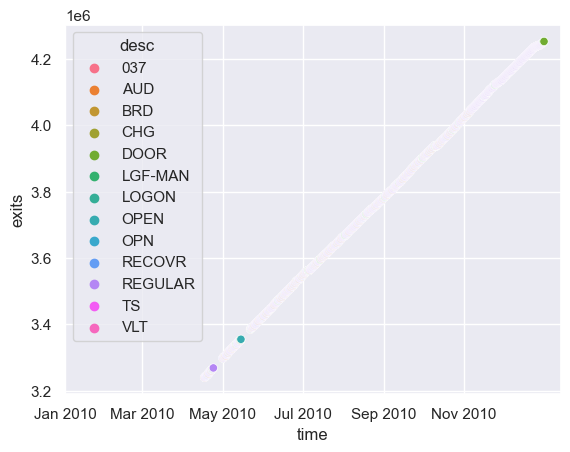

In [265]:
months_interval = [datetime(2010, month, 1) for month in range(1, 13, 2)]
plt.rc('date.autoformatter', day='%b %Y')

sns.scatterplot(x=df_sample.time, y=df_sample.exits, hue=df_sample.desc);
plt.xticks(months_interval);

the values seem to increase at a constant rate. There are a few different values for descs, but these auditions reproduce that growth. Let's check for different ticket gate and station.

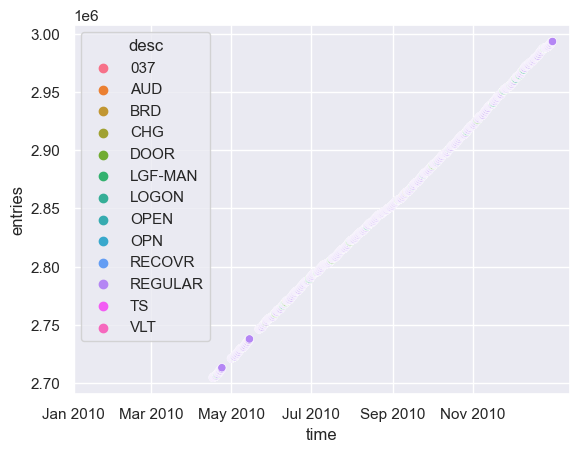

In [268]:
df_sample = df_test[(df_test['station'] == 'LEXINGTON AVE') & (df_test['scp'] == '02-00-00')]

months_interval = [datetime(2010, month, 1) for month in range(1, 13, 2)]
plt.rc('date.autoformatter', day='%b %Y')

sns.scatterplot(x=df_sample.time, y=df_sample.entries, hue=df_sample.desc);
plt.xticks(months_interval);

The same constante count rate. There are any negative diff value?

In [269]:
df_test[(df_test['entries_diff'] < 0) | (df_test['exits_diff'] < 0)]

,time,ca,unit,scp,station,linename,division,desc,entries,exits,entries_diff,exits_diff
608251,2010-05-13 10:47:34,H007,R248,00-00-01,1 AVE,{L},BMT,DOOR,0,0,-15256497.0,-8261779.0
661630,2010-05-22 04:00:00,H008,R248,01-00-00,1 AVE,{L},BMT,REGULAR,6,29330,-346113.0,-6466117.0
3560,2010-04-17 05:00:00,R170,R191,00-00-00,103 ST,{1},IRT,REGULAR,6346852,2296435,-1129097.0,-4253474.0
3800,2010-04-17 05:00:00,R252,R180,00-00-00,103 ST,{6},IRT,REGULAR,2945406,3283522,-3401446.0,987087.0
9508,2010-04-17 09:00:00,R170,R191,00-00-00,103 ST,{1},IRT,REGULAR,6346873,2296462,-1129112.0,-4253529.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7406260,2010-12-31 12:00:00,J032,R006,01-06-01,WOODHAVEN BLVD,"{J, Z}",BMT,REGULAR,469751,332930,-3243433.0,-1865312.0
7411234,2010-12-31 16:00:00,J032,R006,01-06-01,WOODHAVEN BLVD,"{J, Z}",BMT,REGULAR,469887,332972,-3243427.0,-1865284.0
7416078,2010-12-31 20:00:00,J032,R006,01-06-01,WOODHAVEN BLVD,"{J, Z}",BMT,REGULAR,469980,333057,-3243583.0,-1865258.0
2749947,2010-07-29 12:30:05,N094,R029,01-00-03,WORLD TRADE CTR,"{E, A, 2, C, 3}",IND,DOOR,1,0,-796231.0,-468978.0


Some negative values for the instant audit, we should look some points closer.

In [272]:
df_test.loc[range(608251 - 3, 608251 + 3)]

,time,ca,unit,scp,station,linename,division,desc,entries,exits,entries_diff,exits_diff
3797,2010-04-17 05:00:00,R251,R144,00-03-00,96 ST,{6},IRT,REGULAR,9010444,1586349,5741235.0,-803040.0
3798,2010-04-17 05:00:00,R251,R144,00-03-01,96 ST,{6},IRT,REGULAR,14390713,2554961,13895714.0,2088717.0
3799,2010-04-17 05:00:00,R251,R144,00-03-02,96 ST,{6},IRT,REGULAR,7263723,834182,3685908.0,-4404312.0
3800,2010-04-17 05:00:00,R252,R180,00-00-00,103 ST,{6},IRT,REGULAR,2945406,3283522,-3401446.0,987087.0
3801,2010-04-17 05:00:00,R252,R180,00-00-01,103 ST,{6},IRT,REGULAR,9153789,3874653,2242994.0,1689052.0
3802,2010-04-17 05:00:00,R252,R180,00-00-02,103 ST,{6},IRT,REGULAR,7042019,3166036,-2496926.0,-42844.0


Apparently in this 'DOOR' event the counter value was reset and a new cumulative count started.

In [273]:
df_test.loc[range(3800 - 3, 3800 + 3)]

,time,ca,unit,scp,station,linename,division,desc,entries,exits,entries_diff,exits_diff
3797,2010-04-17 05:00:00,R251,R144,00-03-00,96 ST,{6},IRT,REGULAR,9010444,1586349,5741235.0,-803040.0
3798,2010-04-17 05:00:00,R251,R144,00-03-01,96 ST,{6},IRT,REGULAR,14390713,2554961,13895714.0,2088717.0
3799,2010-04-17 05:00:00,R251,R144,00-03-02,96 ST,{6},IRT,REGULAR,7263723,834182,3685908.0,-4404312.0
3800,2010-04-17 05:00:00,R252,R180,00-00-00,103 ST,{6},IRT,REGULAR,2945406,3283522,-3401446.0,987087.0
3801,2010-04-17 05:00:00,R252,R180,00-00-01,103 ST,{6},IRT,REGULAR,9153789,3874653,2242994.0,1689052.0
3802,2010-04-17 05:00:00,R252,R180,00-00-02,103 ST,{6},IRT,REGULAR,7042019,3166036,-2496926.0,-42844.0


Even for a 'REGULAR' audition there was a counter reset. As the count value is cumulative and the difference between these values is preserved if we drop these rows. Furthermore, we will focus this analysis on just those 'REGULAR' auditions that happen periodically every four hours, as a way of simplifying the project.

In [277]:
df_test = df_test[df_test['desc'] == 'REGULAR']
df_test = df_test[(df_test['entries_diff'] >= 0) | (df_test['exits_diff'] >= 0)]
df_test.head()

,time,ca,unit,scp,station,linename,division,desc,entries,exits,entries_diff,exits_diff
376,2010-04-17 04:00:00,H007,R248,00-00-00,1 AVE,{L},BMT,REGULAR,2881236,3240099,0.0,0.0
5376,2010-04-17 08:00:00,H007,R248,00-00-00,1 AVE,{L},BMT,REGULAR,2881370,3240352,134.0,253.0
16292,2010-04-17 16:00:00,H007,R248,00-00-00,1 AVE,{L},BMT,REGULAR,2881942,3241295,498.0,711.0
21278,2010-04-17 20:00:00,H007,R248,00-00-00,1 AVE,{L},BMT,REGULAR,2882594,3242286,652.0,991.0
26220,2010-04-18 00:00:00,H007,R248,00-00-00,1 AVE,{L},BMT,REGULAR,2883280,3243243,686.0,957.0


Let's visualize the time series over the year for a turnstile at a station.

In [278]:
df_sample = df_test[(df_test['station'] == '1 AVE') & (df_test['scp'] == '00-00-00')]

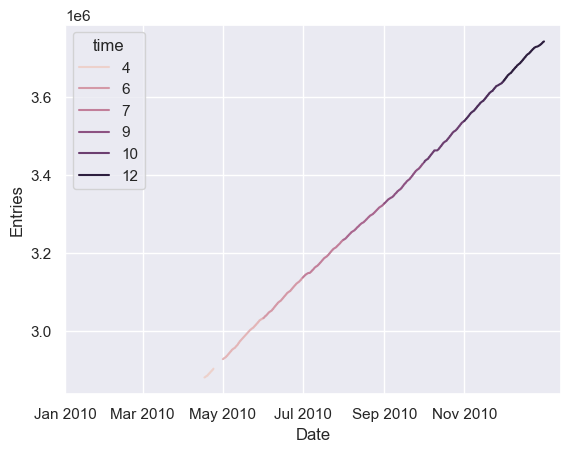

In [280]:
months_interval = [datetime(2010, month, 1) for month in range(1, 13, 2)]
plt.rc('date.autoformatter', day='%b %Y')

sns.lineplot(x=df_sample['time'], y=df_sample['entries'], hue=df_sample.time.dt.month)
plt.xticks(months_interval)
plt.xlabel('Date')
plt.ylabel('Entries');

This 2010 data frame begins in april and the plot show a constante growth rate for the accumulated entries count during the year.

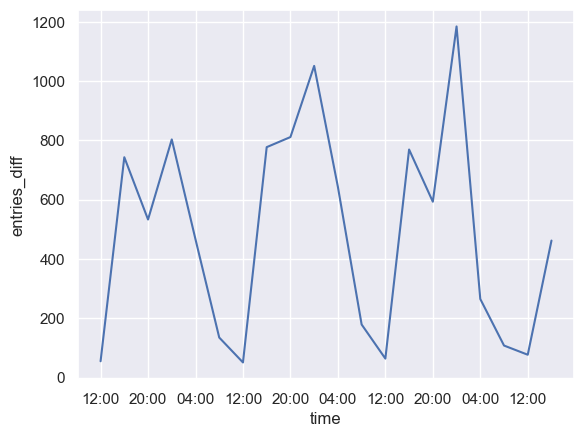

In [285]:
hours_interval = df_sample[-20:].time.to_list()[::2]
plt.rc('date.autoformatter', day='%H:%M')

sns.lineplot(x=df_sample[-20:].time, y=df_sample[-20:].entries_diff)
plt.xticks(hours_interval);

The graph with the number of passengers per hour of a single turnstile shows a typical behavior of a time series, with moments of high and low movement.

### Data Processing Methods

Now let's create some methods to perform this pre-processing of datasets during import.

In [19]:
def time_covariates(df):
    
    time_column = 'time'  
    
    df[time_column] = pd.to_datetime(df[time_column])
    #df['date'] = df[time_column].dt.date
    #df['year'] = df[time_column].dt.year.astype('int16')
    #df['month'] = df[time_column].dt.month.astype('int8')
    #df['weekday'] = df[time_column].dt.weekday.astype('int8')
    #df['day'] = df[time_column].dt.day.astype('int8')
    #df['hour'] = df[time_column].dt.hour.astype('int8')
    
    return df


def object_to_cat(df):
    
    object_columns = [_ for _ in df.columns if df[_].dtype == np.object0]
    
    for column in object_columns:
        df[column] = pd.Categorical(df[column])
    
    return df


def data_grouping(df):
    
    df.dropna(inplace=True)
    df = df[df['desc'] == 'REGULAR'].sort_values(by=['station', 'scp'])
    df['entries_diff'] = df.groupby(['station', 'scp'])['entries'].diff().fillna(0).astype('int')
    df['exits_diff'] = df.groupby(['station', 'scp'])['exits'].diff().fillna(0).astype('int')
    
    df = df[(df['entries_diff'] >= 0) | (df['exits_diff'] >= 0)]
    
    return df

def pre_processing(df):
    
    return data_grouping(object_to_cat(time_covariates(df)))

## Importing Datasets

Declaring the folders.

In [9]:
file_name = 'data/Dataset-Prova.7z'
temp_folder = 'data/temp'

Unpacking the 7zip file.

In [10]:
with py7zr.SevenZipFile(file_name, 'r') as archive:
    archive.extractall(path=temp_folder)

In [11]:
path_data_sets = glob.glob(temp_folder + '/*/*')

Datasets are read from the file, pre-processed using data processing methods, and concatenated into a single data frame.

In [12]:
df = pre_processing(pd.concat([pd.read_csv(_) for _ in path_data_sets], ignore_index=True))

Removing temporary folder with files.

In [13]:
try:
    shutil.rmtree(temp_folder)
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

Exporting the pre-processed file to save time.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66214314 entries, 61857195 to 61851726
Data columns (total 12 columns):
 #   Column        Dtype         
---  ------        -----         
 0   time          datetime64[ns]
 1   ca            category      
 2   unit          category      
 3   scp           category      
 4   station       category      
 5   linename      category      
 6   division      category      
 7   desc          category      
 8   entries       float64       
 9   exits         float64       
 10  entries_diff  int32         
 11  exits_diff    int32         
dtypes: category(7), datetime64[ns](1), float64(2), int32(2)
memory usage: 3.2 GB


In [9]:
df.shape

(66214314, 18)

In [15]:
df.to_parquet('data/df_preprocessed.gzip', compression='gzip')

## Exploratory data analysis

The file is huge, so let's sample some lines.

In [20]:
n_samples = 100_000

In [21]:
df = pd.read_parquet('data/df_preprocessed.gzip').sample(n_samples)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 44225279 to 72534816
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   time          100000 non-null  datetime64[ns]
 1   ca            100000 non-null  category      
 2   unit          100000 non-null  category      
 3   scp           100000 non-null  category      
 4   station       100000 non-null  category      
 5   linename      100000 non-null  category      
 6   division      100000 non-null  category      
 7   desc          100000 non-null  category      
 8   entries       100000 non-null  float64       
 9   exits         100000 non-null  float64       
 10  entries_diff  100000 non-null  int32         
 11  exits_diff    100000 non-null  int32         
dtypes: category(7), datetime64[ns](1), float64(2), int32(2)
memory usage: 5.0 MB
